In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import pickle
from enum import Enum

In [2]:
#make observer

In [3]:
class Genome:
        
    def __init__(self, seed, length=1000, cohesin_stopper_p=0.1, condensin_stopper_p=0.3):
        np.random.default_rng(seed)
        no_stopper_p = 1 - cohesin_stopper_p - condensin_stopper_p
        self.array = np.random.choice([0,1,2], size=length, p=[no_stopper_p, cohesin_stopper_p, condensin_stopper_p])
        self.occupited = {i: False for i in range(length)}
        
        
    def get_length(self):
        return len(self.array)
        
    def get_array(self):
        return self.array
    
    def is_occupited(self, index):
        return self.occupited[index]
    
    def update_occupited(self, index, status=True):
        self.occupited[index] = status
        
    def __str__(self):
        return str(self.array)
            
        

In [4]:
np.set_printoptions(threshold=np.inf)
g = Genome(1)
g.is_occupited(5)

False

In [5]:
g.update_occupited(5)
g.is_occupited(5)

True

In [6]:
class Extruder:
    
    def __init__(self, stalling_prob):
        self.dissociate_prob = 1 - stalling_prob
        self.stalling_prob = stalling_prob
        
        self.active = True
        self.is_left = True
        self.is_right = True
        self.bind = False
        
        self.current_left = None
        self.current_right = None
        
    def set_left(self, i_left):
        if self.is_left:
            self.current_left = i_left
        
    def set_right(self, i_right):
        if self.is_right:
            self.current_left = i_right
            
    def is_active(self):
        if self.is_left or self.is_right:
            self.active = True
        else:
            self.active = False
        return self.active
        
    def is_bind(self):
        return self.bind
    
    def bound(self):
        self.bind = True
        
    def set_position(self, i_left, i_right):
        if self.is_left:
            self.current_left = i_left
        if self.is_right:
            self.current_right = i_right
        else:
            None
        
    def get_position(self):
        return self.current_left, self.current_right
    

In [7]:
class Cohesin(Extruder):
    
    def stop_i(self):
        return 1
    
    def __str__(self):
        return "Cohesin at {}".format(self.get_position())

In [8]:
class Condensin(Extruder):
    
    def stop_i(self):
        return 2
    
    def __str__(self):
        return "Condensin at {}".format(self.get_position())

In [9]:
cohesin = Cohesin(0)

In [10]:
print(cohesin)

Cohesin at (None, None)


In [11]:
class ExtruderType(Enum):
    COHESIN = 1
    CONDENSIN = 2

In [12]:
ExtruderType.COHESIN

<ExtruderType.COHESIN: 1>

In [13]:
class ExtruderFactory:
    
    def get(e_type, stalling_prob=1):
        
        return {
            ExtruderType.COHESIN: Cohesin(stalling_prob),
            ExtruderType.CONDENSIN: Condensin( stalling_prob)
        }.get(e_type,0)
            

In [14]:
ExtruderFactory.get(ExtruderType.COHESIN, 0)

In [15]:
class Simulator:
    
    def __init__(self, genome, seed, n_extruders=1000, option="cohesin"): 
        np.random.seed(seed)
        self.genome = genome
        self.genome_length = genome.get_length()
        self.extruder_factory = ExtruderFactory
        self.extruders = self._check_option(n_extruders, option)
        self.extruders_per_i = int(n_extruders)
        self.bound = list()
        self.unbound = list()
        self.n_bound = list()
        self.n_active = list()
        self.time = 0
        
    def simulate(self, time):
        self.time += time
        for i in range(time):
            self._simulate_one_step(i)
            self.n_bound.append(len(self.bound))
            self.n_active.append(sum([e.is_active() for e in self.extruders]))
    
    def plot(self):
        ts = [i for i in range(self.time)]
        plt.plot(ts, self.n_bound, label="bound")
        plt.plot(ts, self.n_active, label="active")
#         plt.legend()
#         plt.show()
#         print(self.n_bound[-1], self.n_active[-1])
    
    def plot_fold(self):
        for i, x in enumerate(self.extruders):
            start, end = x.get_position()
            if start != None and end != None:
                xs = np.linspace(start,end)
                ys = [x.stop_i() for j in range(len(xs))]
                plt.plot(xs, ys)
            
        
    def _simulate_one_step(self, i):
        if i*self.extruders_per_i < len(self.extruders):
            start_sites = self._get_start_sites(self.extruders_per_i)
            for site, index in enumerate(range(i*self.extruders_per_i, (i+1)*self.extruders_per_i)):
                l_site = start_sites[site]
                self._sim_one_helper(l_site, index, False)
#         while len(self.unbound) > 0:
        start_sites = self._get_start_sites(len(self.unbound))
        for site, index in enumerate(self.unbound):
            # print(site)
            # print(len(start_sites))
            l_site = start_sites[site]
            self._sim_one_helper(l_site, index, True)
        self._extrude()
        
    def _sim_one_helper(self, l_site, index, second):
        r_site = l_site + 1
        extruder = self.extruders[index]
        if not (self.genome.is_occupited(l_site) or self.genome.is_occupited(r_site)):
            extruder.set_position(l_site, r_site)
            self.genome.update_occupited(l_site)
            self.genome.update_occupited(r_site)
            extruder.bound()
            self.bound.append(index)
            if second:
                self.unbound.remove(index)
            pass
        if not second:
            self.unbound.append(index)
        
    def _extrude(self):
        for j in self.bound:
                extruder = self.extruders[j]
                left, right = extruder.get_position()
                n_left = left-1
                n_right = right+1
                if n_left < 0:
                    n_left = self.genome_length-1
                if n_right >= self.genome_length:
                    n_right = 0
                if not self.genome.is_occupited(n_left):
                    extruder.set_left(n_left)
                    self.genome.update_occupited(n_left)
                    self.genome.update_occupited(left, False)
                    if self.genome.array[n_left] == extruder.stop_i():
                        extruder.is_left = False
                else:
                    extruder.is_left = False
                if not self.genome.is_occupited(n_right):
                    extruder.set_right(n_right)
                    self.genome.update_occupited(n_right)
                    self.genome.update_occupited(right, False)
                    if self.genome.array[n_right] == extruder.stop_i():
                        extruder.is_right = False
                else:
                    extruder.is_right = False
                extruder.is_active()            
                
    def _check_option(self, n_extruder, option):
        choices = {
            "cohesin" : [self.extruder_factory.get(ExtruderType.COHESIN) for i in range(n_extruder)],
            "both" : [self.extruder_factory.get(ExtruderType.COHESIN) for i in range(n_extruder)]
        } 
        choices["both"].extend([self.extruder_factory.get(ExtruderType.CONDENSIN) for i in range(n_extruder)])
        np.random.shuffle(choices[option])
        return choices[option]
        
    def _get_start_sites(self,extruders_per_i):
        return np.random.randint(0, self.genome_length-2, extruders_per_i)
          
    
            
        
        
    

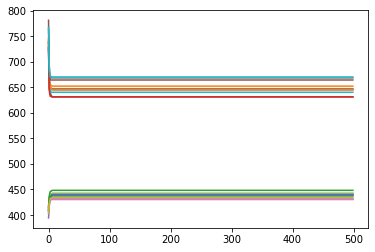

In [16]:
for i in range(10):
    sim = Simulator(Genome(1),i)
    sim.simulate(500)
    sim.plot()
# plt.legend()
plt.show()

436
654
935


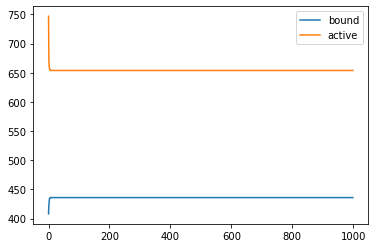

In [17]:
sim = Simulator(Genome(1),1)
sim.simulate(1000)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(len(sim.unbound))
plt.legend()
plt.show()

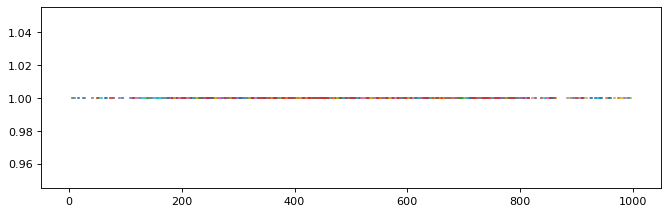

In [18]:
plt.figure(figsize=(10, 3), dpi=80)
sim.plot_fold()

433
500
640


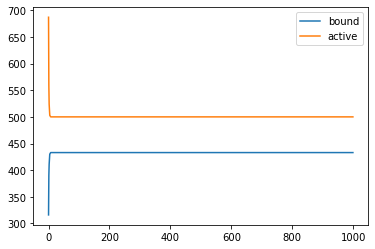

In [19]:
sim = Simulator(Genome(1),1, n_extruders=400, option="both")
sim.simulate(1000)
sim.plot()
print(sim.n_bound[-1])
print(sim.n_active[-1])
print(len(sim.unbound))
plt.legend()
plt.show()

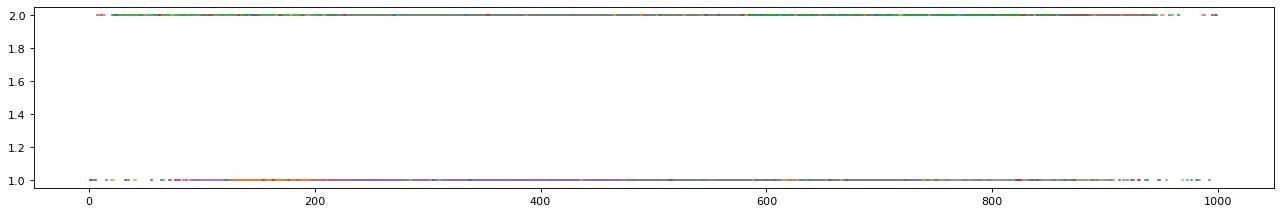

In [20]:
plt.figure(figsize=(20, 3), dpi=80)
sim.plot_fold()